In [1]:
import torch
from torch import nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

import datetime
# auto reolad zewnetrznych skryptow bez resetowania notebooka
import sys
sys.path.append('..')
import models
from utils.modeling_utils import SequenceGeneratorCV

%reload_ext autoreload
%autoreload 2

DEVICE = "cpu"

# Data prep

In [2]:
df = pd.read_csv('../../data/csv/six_cities.csv')
df['dt'] = pd.to_datetime(df['dt'])
df = df.reset_index(drop=True)
df.head()

,city,dt,day_sin,day_cos,week_sin,week_cos,month_sin,month_cos,temp,feels_like,...,snow.1h,co,no,no2,o3,so2,pm2_5,pm10,nh3,state
0,Warszawa,2022-04-29 18:00:00,-1.000000,-3.879892e-12,1.000000,3.455899e-14,-0.580455,0.814292,13.73,12.54,...,0.0,1922.61,121.59,85.00,0.05,381.47,155.11,172.36,25.59,Masovian Voivodeship
1,Warszawa,2022-04-29 19:00:00,-0.965926,2.588190e-01,0.999301,-3.739119e-02,-0.573430,0.819255,12.24,11.14,...,0.0,2563.48,175.24,95.96,0.00,549.32,225.09,248.15,35.97,Masovian Voivodeship
2,Warszawa,2022-04-29 20:00:00,-0.866025,5.000000e-01,0.997204,-7.473009e-02,-0.566362,0.824157,11.16,10.08,...,0.0,2830.51,189.54,102.82,0.00,610.35,259.14,287.34,42.56,Masovian Voivodeship
3,Warszawa,2022-04-29 21:00:00,-0.707107,7.071068e-01,0.993712,-1.119645e-01,-0.559252,0.828997,9.69,9.69,...,0.0,2269.74,139.47,94.59,0.00,473.02,205.92,235.75,41.54,Masovian Voivodeship
4,Warszawa,2022-04-29 22:00:00,-0.500000,8.660254e-01,0.988831,-1.490423e-01,-0.552101,0.833777,9.28,9.28,...,0.0,1428.60,74.21,72.66,0.00,242.23,119.94,144.66,30.91,Masovian Voivodeship


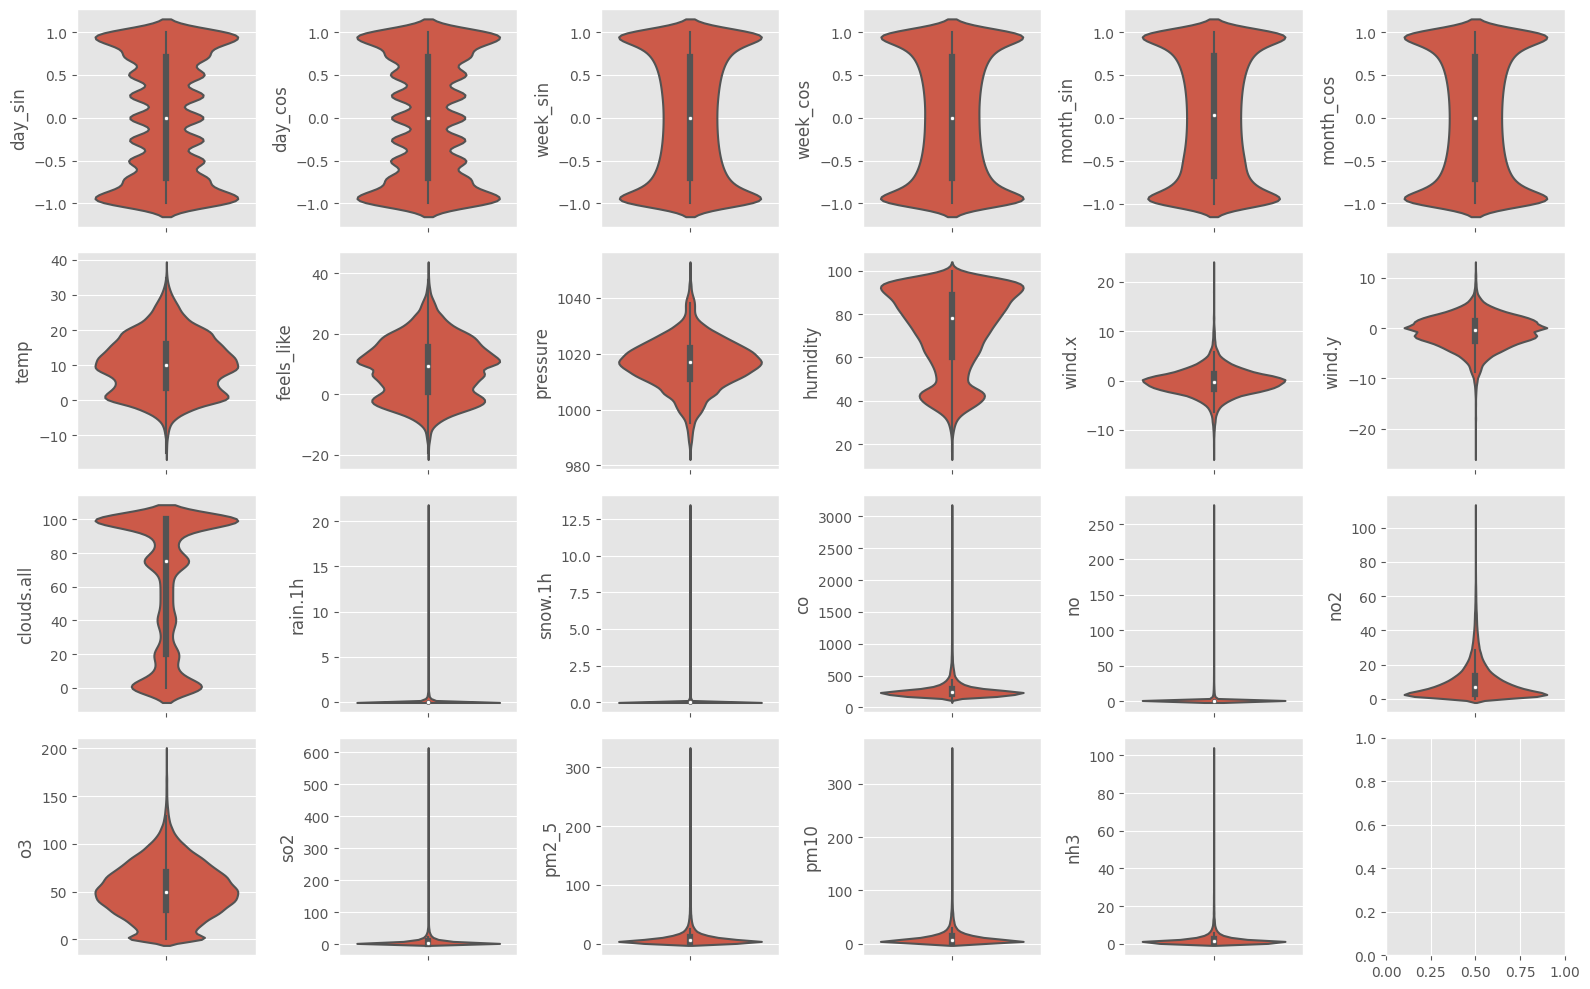

In [3]:
def viol_plot(df):
    cols = df.columns[2:-1]
    fig, axes = plt.subplots(4, 6, figsize=(16, 10))
    axes = axes.ravel()

    for i, v in enumerate(cols):
        sns.violinplot(df, y=v, ax=axes[i])

    fig.tight_layout()
viol_plot(df)

In [4]:
# na podstawie 96 godzin predykcja na dwa nastepne dni
input_width, output_width = 96, 48

# one moga zostac bez problemu jako stala czy cos, maja rozklady bardzo nienormalne
normalize_features = ['humidity', 'clouds.all', 'rain.1h', 'snow.1h', 'co', 'no', 'no2', 'so2', 'pm2_5', 'pm10', 'nh3']

# zmienne numeryczne ktore chcemy wykorzystac w modelu
numeric_features = ['day_sin', 'day_cos', 'week_sin', 'week_cos', 'month_sin',
       'month_cos', 'temp',  'pressure', 'humidity', 'wind.x',
       'wind.y', 'clouds.all', 'rain.1h', 'snow.1h', 'co', 'no', 'no2', 'o3',
       'so2', 'pm2_5', 'pm10', 'nh3',]

# numeric_features = ['day_sin', 'day_cos', 'week_sin', 'week_cos', 'month_sin',
#        'month_cos', 'co', 'no']

# zmienne kategoryczne ktore chcemy wykorzystac w modelu
# categorical_features = ['state']

# zmienne ktorych chcemy robic predykcje
output_columns = ['co', 'no', 'no2', 'o3', 'so2', 'pm2_5', 'pm10', 'nh3']
# output_columns = ['co', 'no']

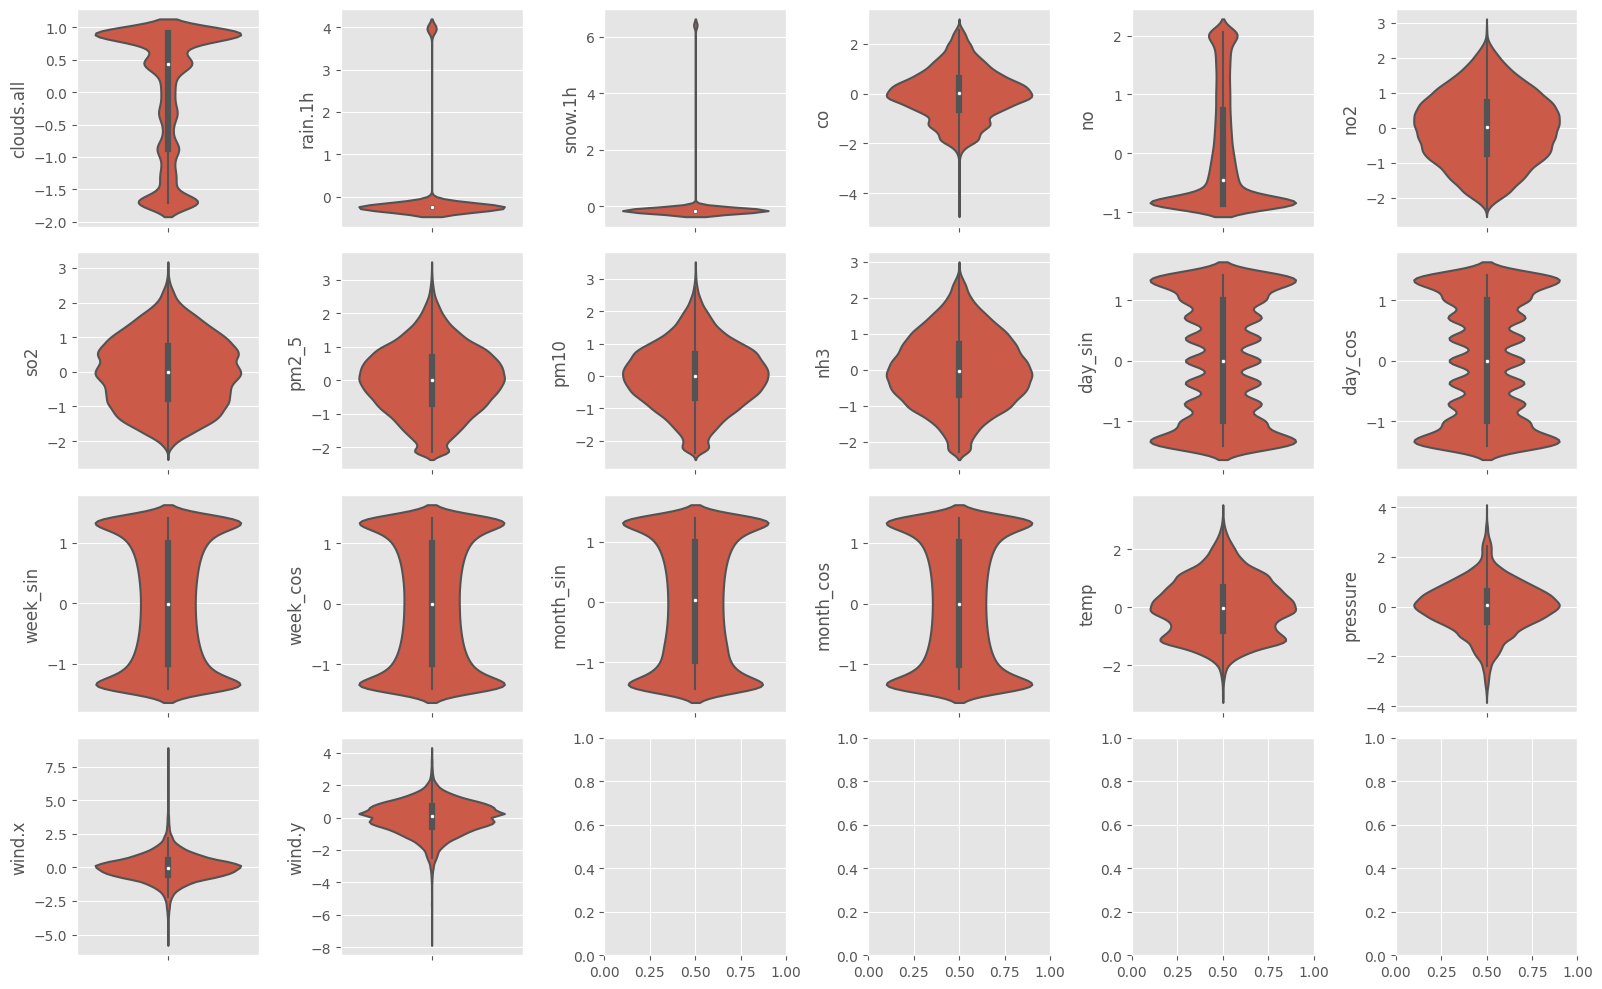

In [5]:
seq_gen = SequenceGeneratorCV(
    numeric_features = numeric_features, 
    categorical_features = [],
    output_features=output_columns,
    normalize_features = normalize_features,
    device = DEVICE 
)
seq_gen.init_preprocessor(df[:10])
viol_plot(seq_gen.preprocessor.fit_transform(df))